# Model Cartoon Plots

This quick tutorial showcases the `plot_model_cartoon()` function, which is part of the HSSM `plotting` submodule. 
The idea with these plots is to provide a pictorial representation of the underlying process that we recover with our model fits. 
You can explore various options to include posterior uncertainty graphically in these plots. 

### Import Modules


In [ ]:
from pathlib import Path

import arviz as az
import numpy as np
import pandas as pd

import hssm
import hssm.plotting

%matplotlib inline
%config InlineBackend.figure_format='retina'

## 2 Choice Models

### Read Files

In [ ]:
fixtures_dir = Path("../../tests/fixtures")
cav_data_test = pd.read_csv(fixtures_dir / "cavanagh_theta_test.csv")
cav_data_traces = az.from_netcdf(fixtures_dir / "cavanagh_idata.nc")

### Build and sample HSSM model

In [ ]:
# Model parameter specification
cav_model = hssm.HSSM(
    model="angle",
    data=cav_data_test,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Normal", "mu": 0.0, "sigma": 1.5},
            },
            "formula": "v ~ 1 + stim",
            "link": "identity",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {"name": "Normal", "mu": 1.5, "sigma": 0.5},
            },
            "formula": "a ~ 1 + (1|participant_id)",
            "link": "identity",
        },
    ],
    p_outlier=0.00,
)

You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.
No common intercept. Bounds for parameter a is not applied due to a current limitation of Bambi. This will change in the future.
Model initialized successfully.


In [ ]:
idata_cav = cav_model.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=False),  # no need to return likelihoods here
)

Using default initvals. 

The model has already been sampled. Overwriting the previous inference object. Any previous reference to the inference object will still point to the old object.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


### Model Cartoon Plots (2 choices)

#### Fully decomposed

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


Output()

Output()

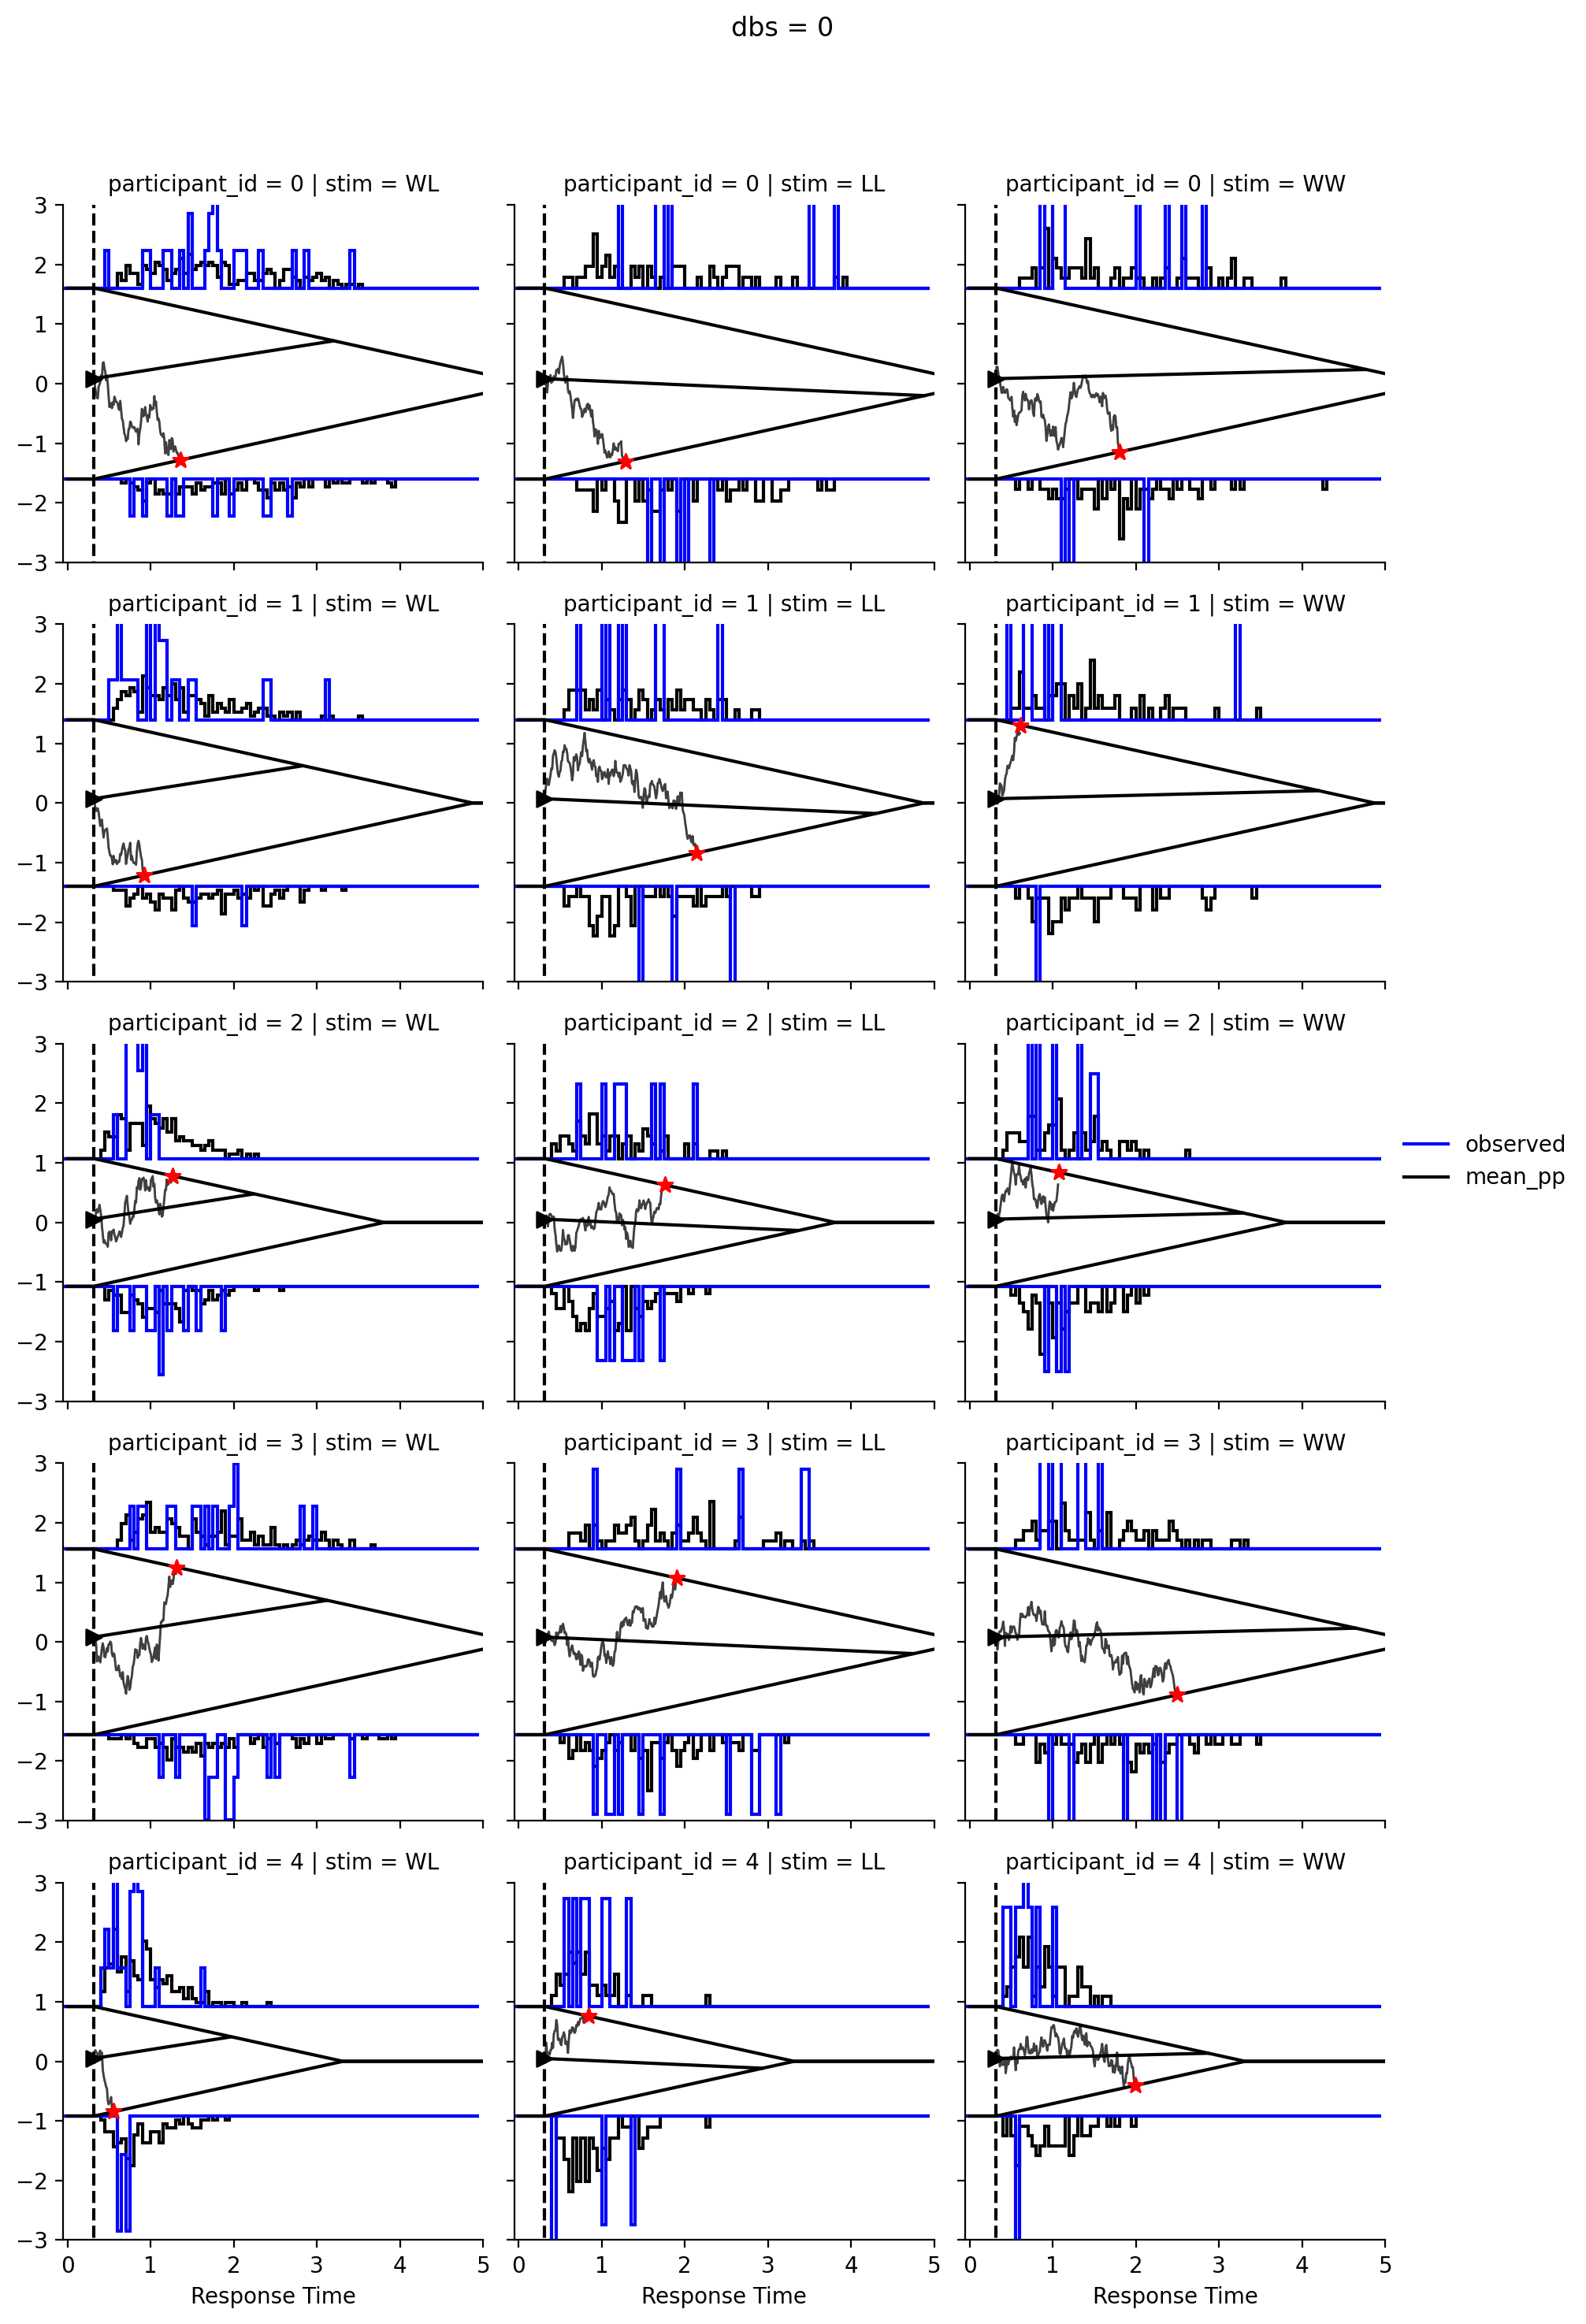

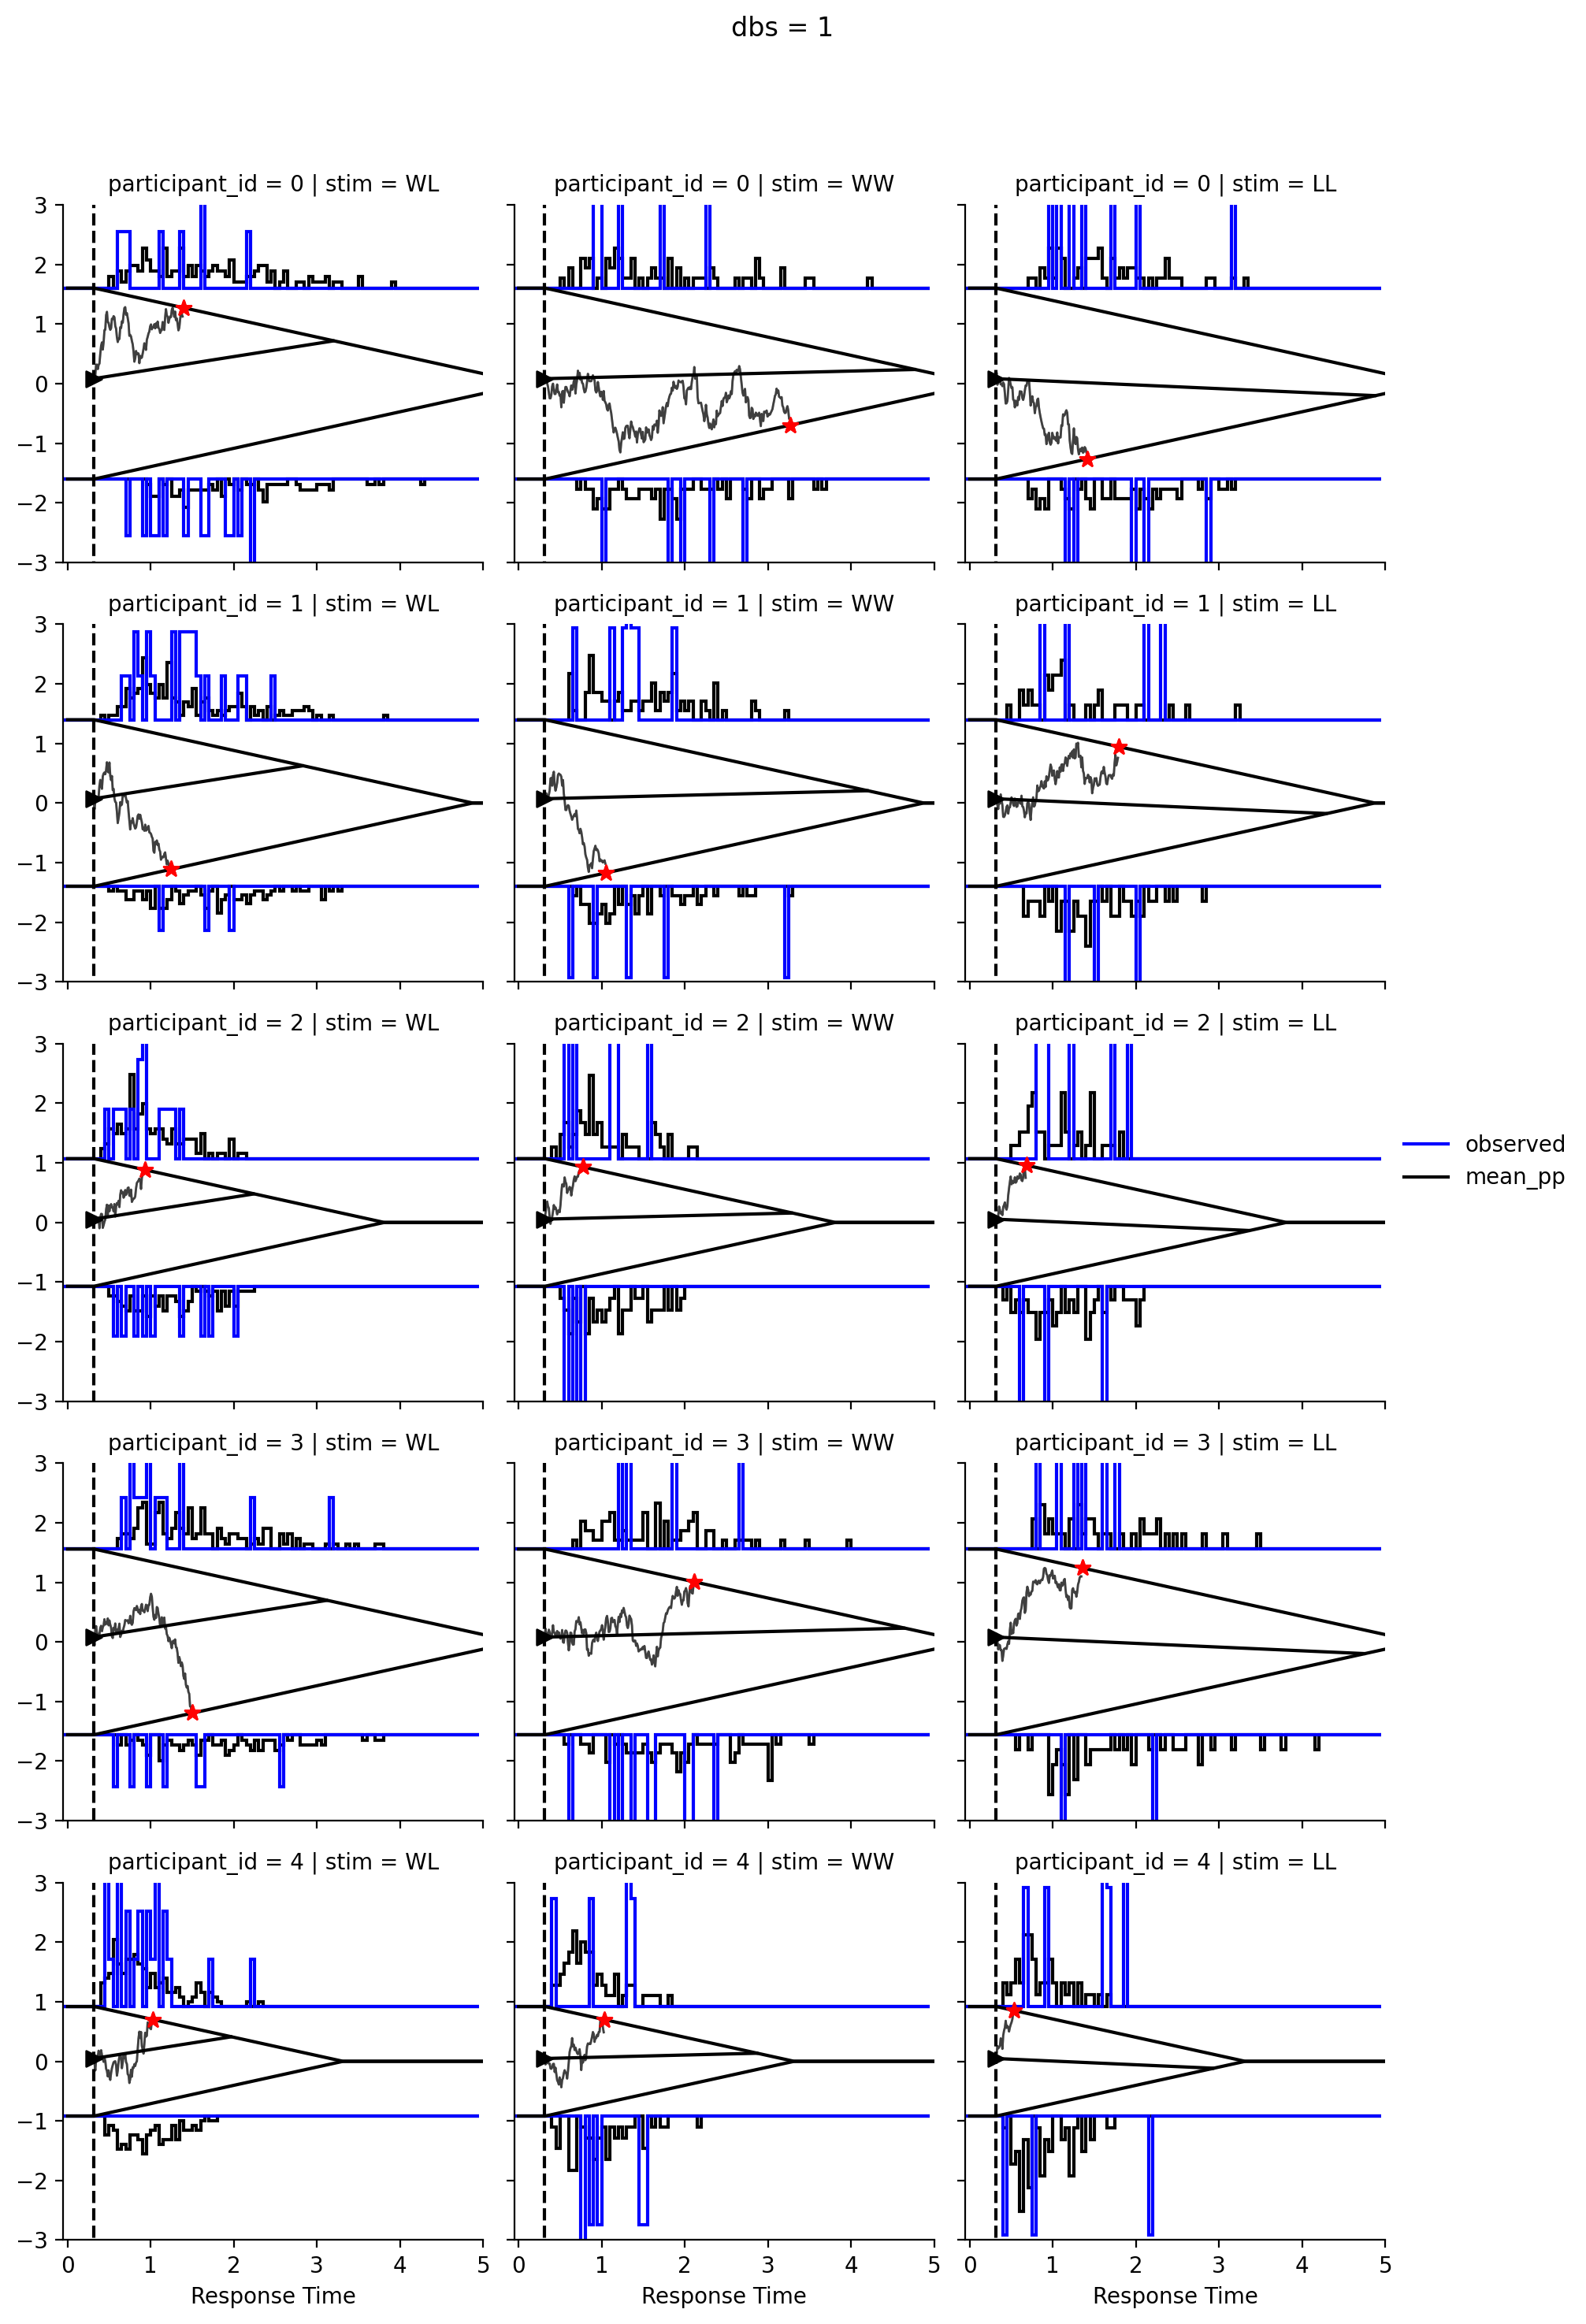

In [ ]:
ax = hssm.plotting.plot_model_cartoon(
    cav_model,
    n_samples=10,
    bins=20,
    col="stim",
    row="participant_id",
    groups=["dbs"],
    plot_pp_mean=True,
    plot_pp_samples=False,
    alpha=0.005,
    n_trajectories=2,  # extra arguments for the underlying plot_model_cartoon() function
);

#### No split by group | Inclue posterior uncertainty

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


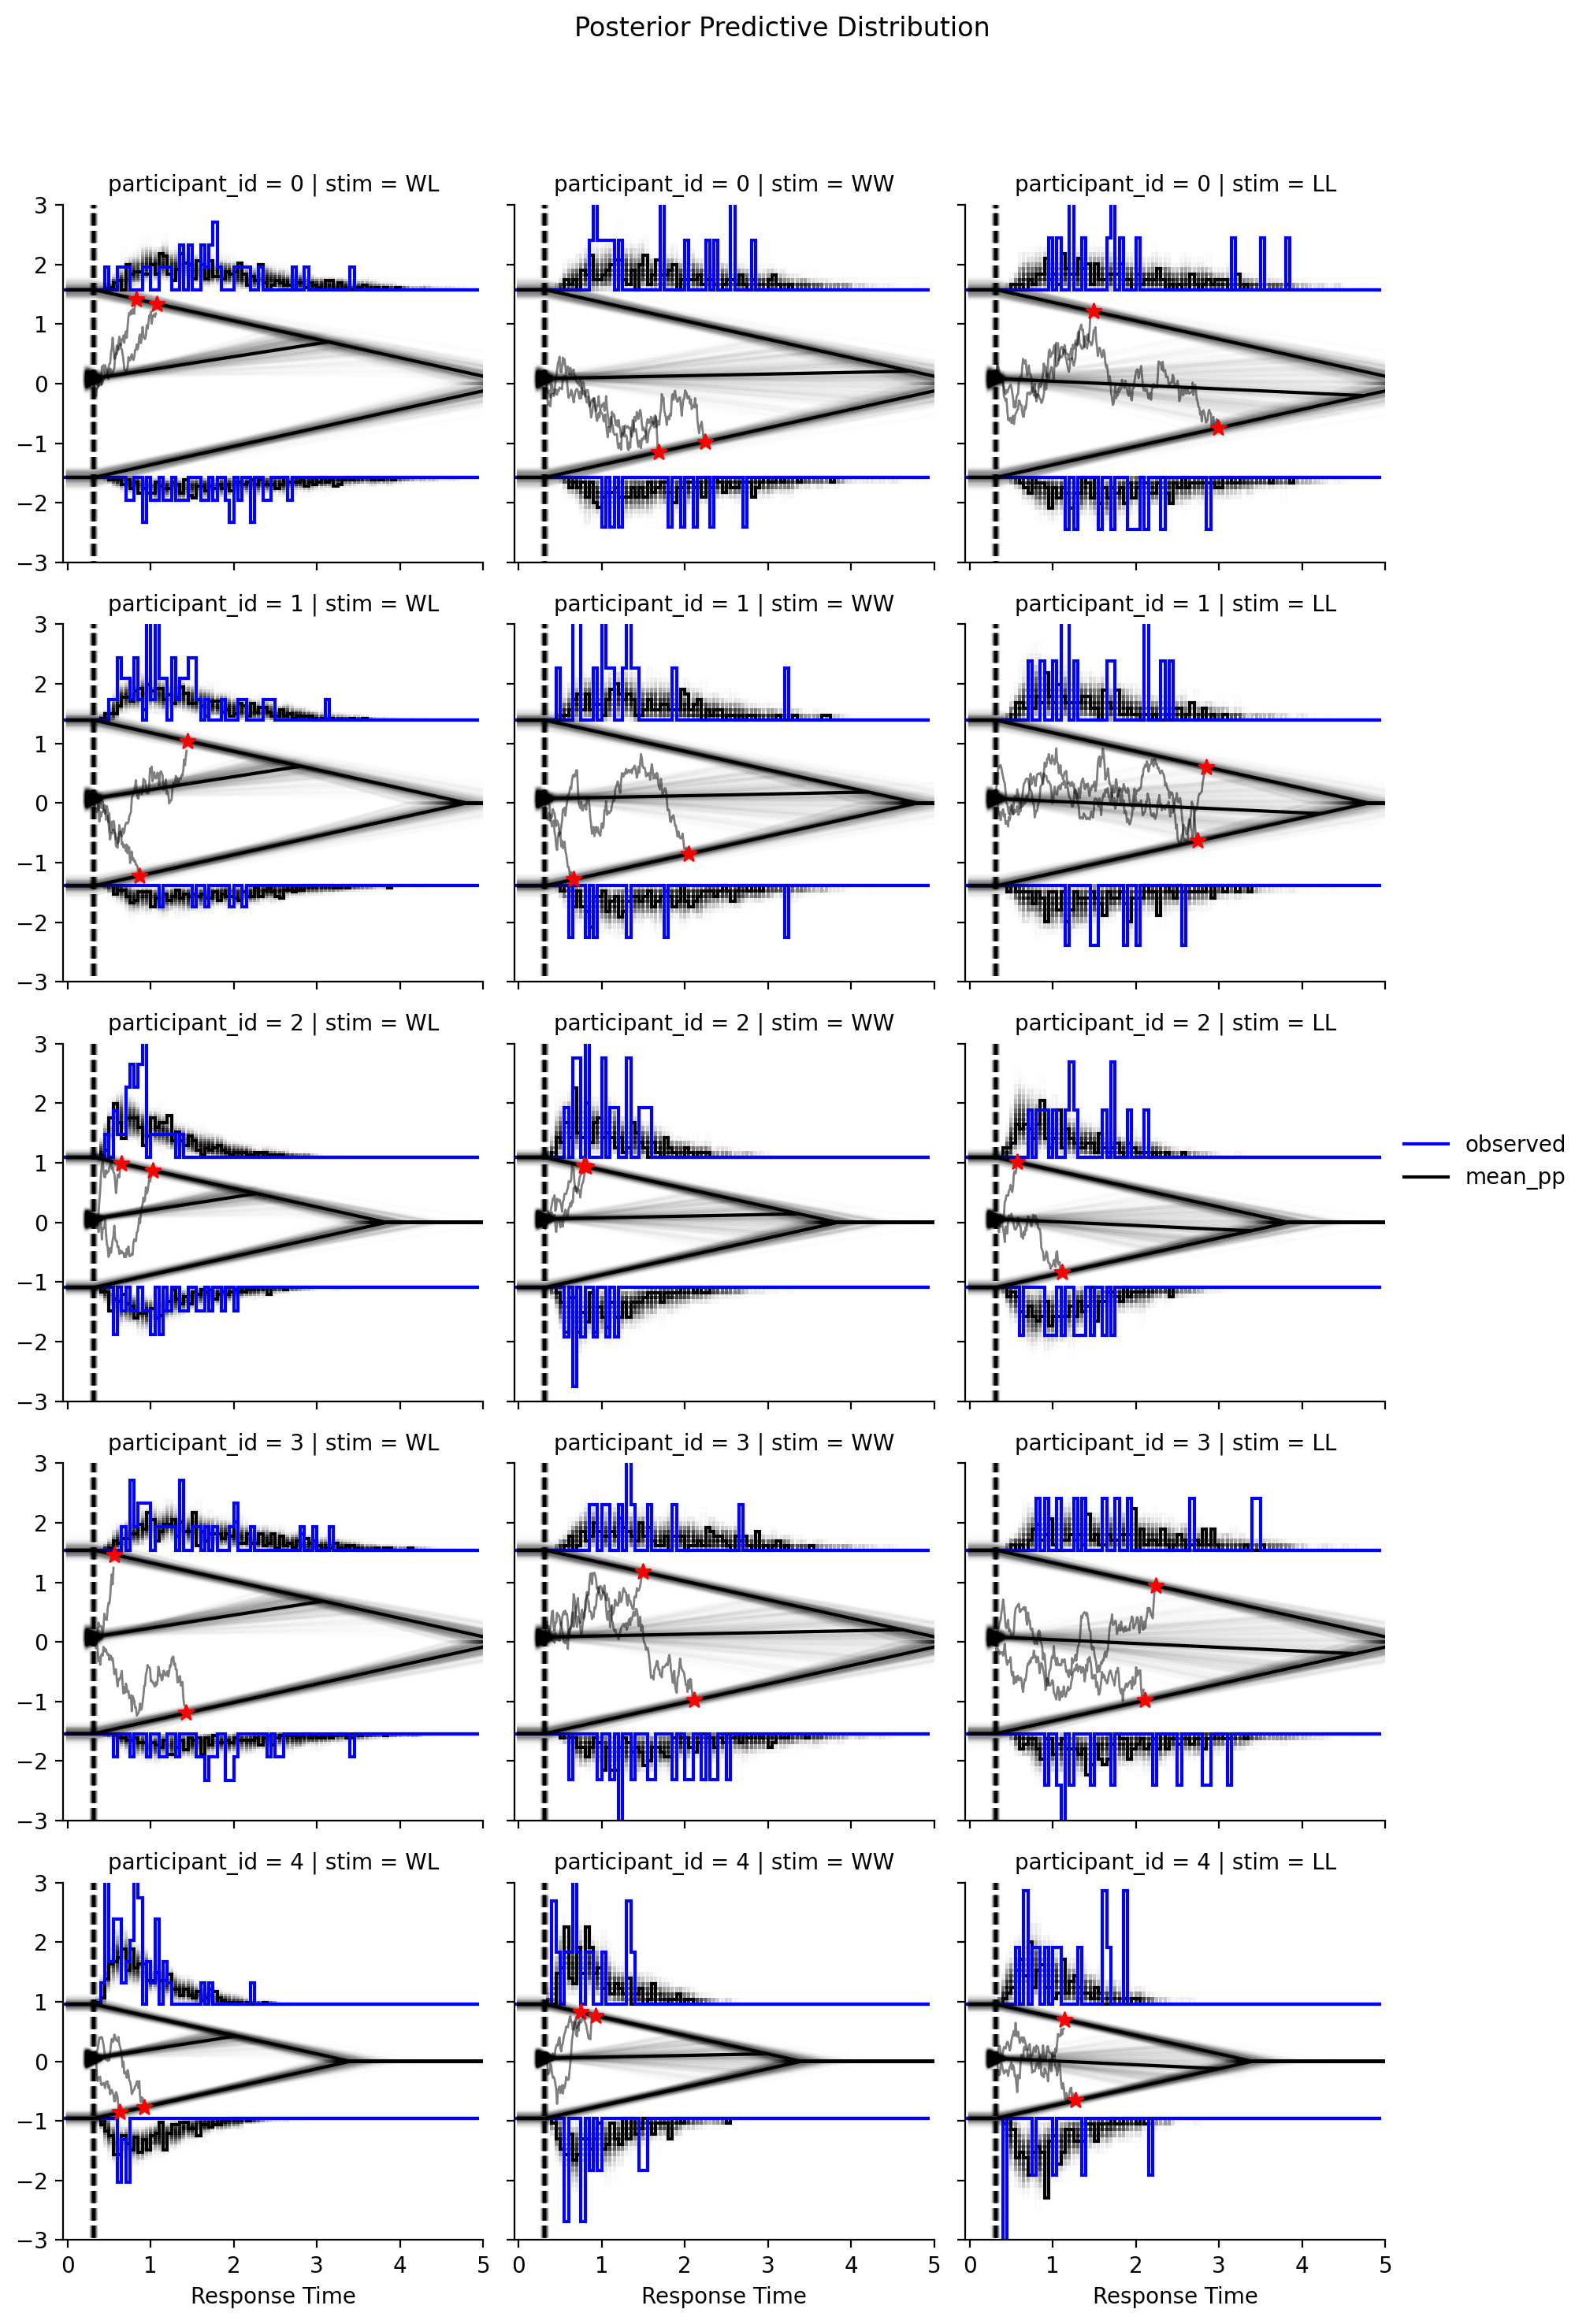

In [ ]:
ax = hssm.plotting.plot_model_cartoon(
    cav_model,
    n_samples=100,
    bins=10,
    col="stim",
    row="participant_id",
    plot_pp_mean=True,
    plot_pp_samples=True,
    alpha_mean=1.0,
    alpha_pp=0.01,
    alpha_trajectories=0.5,
    n_trajectories=2,  # extra arguments for the underlying plot_model_cartoon() function
);

## N Choice Models

### Simulate data

In [ ]:
stim_v = [0.0, 0.75, 1.0]
stim_names = ["low", "medium", "high"]
datasets = []

a_vec = np.random.normal(loc=1.25, scale=0.3, size=5)

for v_tmp in stim_v:
    for participant_id in range(5):
        a_tmp = a_vec[participant_id]
        data_tmp = hssm.simulate_data(
            model="race_no_bias_angle_4",
            theta=dict(
                a=a_tmp,
                v0=v_tmp,
                v1=v_tmp + 0.25,
                v2=v_tmp + 0.5,
                v3=v_tmp + 0.75,
                z=0.5,
                t=0.2,
                theta=0.1,
            ),
            size=200,
        )
        data_tmp["stim"] = stim_names[stim_v.index(v_tmp)]
        data_tmp["participant_id"] = str(participant_id)
        datasets.append(data_tmp)

dataset = pd.concat(datasets).reset_index(drop=True)
param_dict = {
    "v": {
        "low": np.repeat(stim_v[0], 5),
        "medium": np.repeat(stim_v[1], 5),
        "high": np.repeat(stim_v[2], 5),
    },
    "a": {"participant_id"},
}

### Build and sample HSSM Model

In [ ]:
race_model = hssm.HSSM(
    model="race_no_bias_angle_4",
    data=dataset,
    include=[
        {
            "name": "v0",
            "prior": {
                "Intercept": {"name": "Normal", "mu": 0.0, "sigma": 1.5},
            },
            "formula": "v0 ~ 1 + stim",
            "link": "identity",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {"name": "Normal", "mu": 1.5, "sigma": 0.5},
            },
            "formula": "a ~ 1 + (1|participant_id)",
            "link": "identity",
        },
    ],
    p_outlier=0.00,
)

You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.


No common intercept. Bounds for parameter a is not applied due to a current limitation of Bambi. This will change in the future.
Model initialized successfully.


In [ ]:
idata_race = race_model.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=False),  # no need to return likelihoods here
)

Using default initvals. 



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

There were 1000 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Model Cartoon Plot

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


Output()

Output()

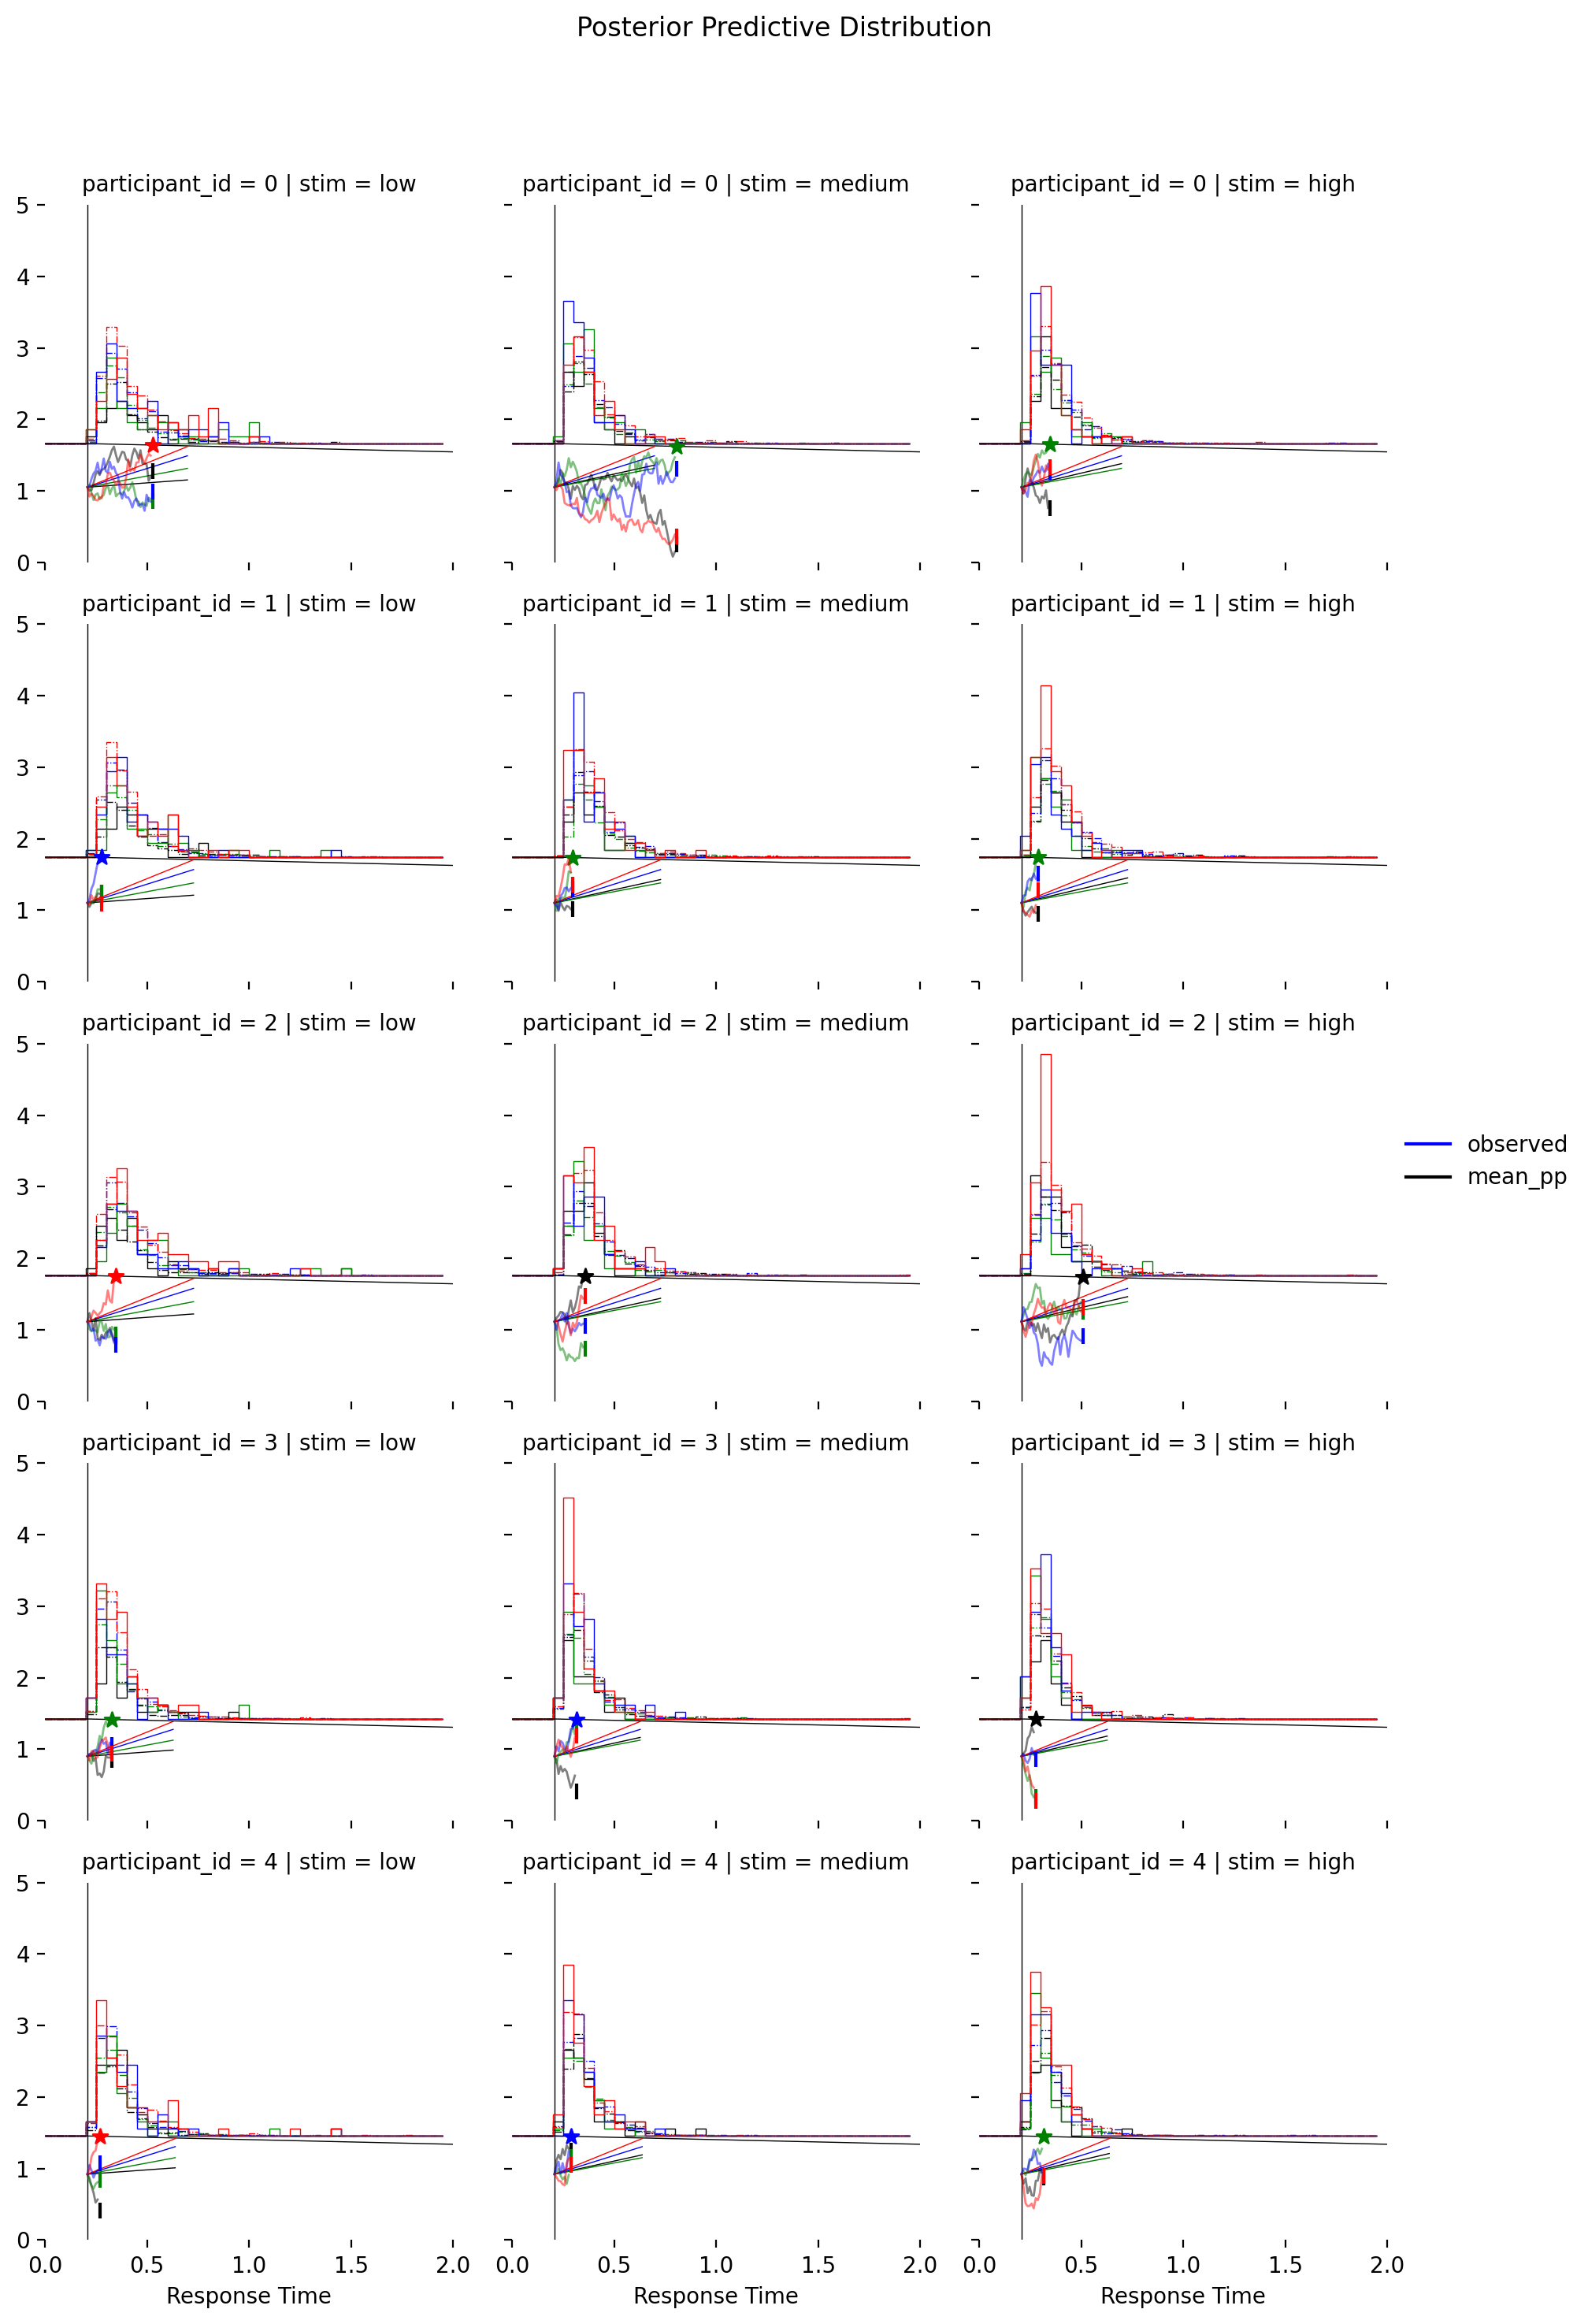

In [ ]:
ax = hssm.plotting.plot_model_cartoon(
    race_model,
    n_samples=10,
    col="stim",
    row="participant_id",
    plot_pp_mean=True,
    plot_pp_samples=False,
    n_trajectories=1,
    ylims=(0, 5),
    alpha_pp=0.2,
    xlims=(0.0, 2),
);